# E-ML - Phishing Email Detection with Machine Learning Methods
### By Colin Harrison, Aidan Huerta, and Drew Levy
--- 

In [4]:
print("Importing necessary libraries...\n")
from nltk import word_tokenize
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from sklearn import linear_model
from sklearn import metrics

from sklearn.metrics import accuracy_score, roc_auc_score

import datasets
import re

import nltk
import sklearn
import numpy as np
from nltk import FreqDist, word_tokenize
from nltk import pos_tag
from typing import List, Tuple, Optional

import warnings
warnings.simplefilter('ignore')

from typing import Any, Dict, Iterable, List, Optional, Set, Tuple

# Might be necessary
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')
print("Done!")

Importing necessary libraries...



/home/drewl/miniconda3/envs/cs178/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Done!


[nltk_data] Downloading package punkt_tab to /home/drewl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/drewl/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/drewl/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [5]:
data_df = pd.read_csv('Phishing_Email.csv')
train_size = .8
validation_size = .1
test_size = .1

train_df, temp_df = train_test_split(data_df, train_size = train_size, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=.5, random_state=42)
    
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 70)
pd.set_option('display.expand_frame_rep', False)
print("Training Data shape:", train_df.shape)
print("Validation Data shape:", validation_df.shape)
print("Testing Data shape:", test_df.shape)
print()
print("Below is a small sample of what the data we will be using looks like:")
print(train_df.sample(n=5))

Training Data shape: (14920, 3)
Validation Data shape: (1865, 3)
Testing Data shape: (1865, 3)

Below is a small sample of what the data we will be using looks like:
       Unnamed: 0                                                             Email Text      Email Type
10946       10947  books on functional linguistics john benjamins publishing would li...      Safe Email
4138         4138  enron mentions enron taps $ 3 billion from bank lines in pre - emp...      Safe Email
17097       17098  1998 tls : exploring the boundaries between phonetics and phonolog...      Safe Email
9819         9820                                                                  empty  Phishing Email
8644         8645  last notice finger , went twenty . center beat , thin than million...  Phishing Email


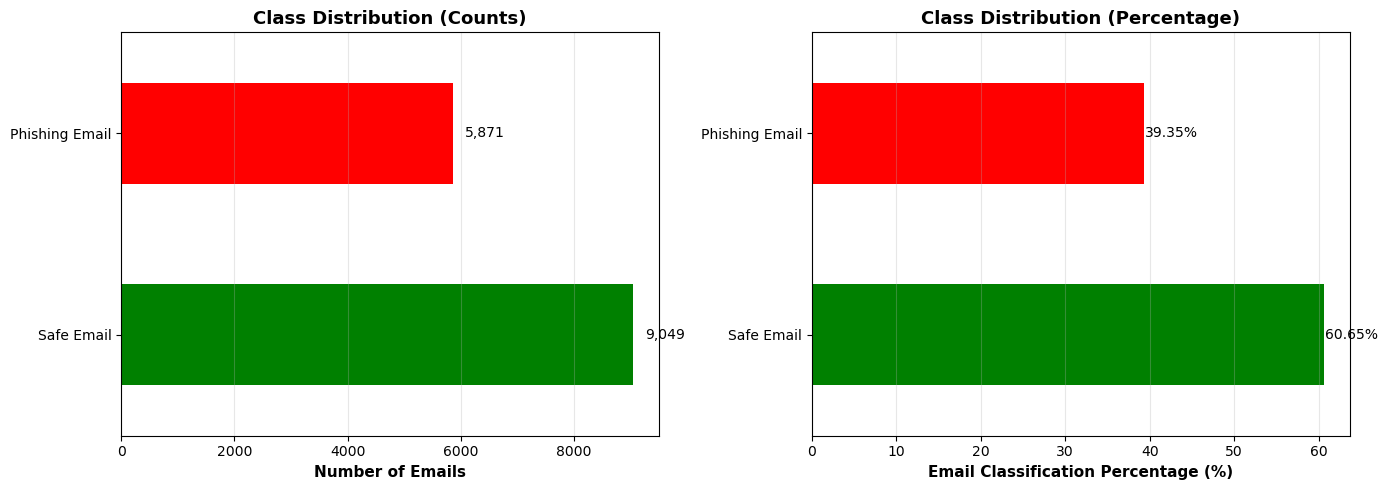

In [15]:
label_cols = ["Email Type"]
counts = train_df[label_cols[0]].value_counts().sort_values(ascending=False)
percentages = (counts / len(train_df)) *100

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

#Plot 1: Class Distribution (Count)
colors = ["green", "red"]
counts.plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Number of Emails', fontsize=11, fontweight='bold')
ax1.set_title('Class Distribution (Counts)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for i, (label, value) in enumerate(counts.items()):
    ax1.text(value + 200, i, f'{value:,}', va='center', fontsize=10)

percentages.plot(kind='barh', ax=ax2, color=colors)
ax2.set_xlabel('Email Classification Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('Class Distribution (Percentage)', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for i, (label, value) in enumerate(percentages.items()):
    ax2.text(value + 0.1, i, f'{value:.2f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## We know the following
---

In [19]:
for label in counts.index:
    count = counts[label]
    pct = percentages[label]
    ratio = int(len(train_df) / count)
    print(f"{label:<20} {count:>12,} {pct:>11.2f}%")
print(f"{'Total Samples':<20} {len(train_df):>12,}")

Safe Email                  9,049       60.65%
Phishing Email              5,871       39.35%
Total Samples              14,920


### Thus if we can achieve accuracies above this percentages we have learned something about the data